In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os 
import tensorflow
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout 
from keras import metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
H1 = pd.read_csv('/content/Hotel H1.csv')
H2 = pd.read_csv('/content/Hotel H2.csv')

In [ ]:
H1['hotel']=0
H2['hotel']=1

In [ ]:
df = pd.concat([H1,H2])

In [ ]:
df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,hotel
0,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,0
1,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,0
2,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,0
3,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,0
4,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03,0


In [ ]:
df.shape

(119390, 32)

In [ ]:
df.tail()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,hotel
79325,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06,1
79326,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07,1
79327,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07,1
79328,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07,1
79329,0,205,2017,August,35,29,2,7,2,0.0,0,HB,DEU,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,151.20,0,2,Check-Out,2017-09-07,1


In [ ]:
df.sample(5)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,hotel
7469,1,70,2016,February,9,26,0,2,1,0.0,0,BB,NLD,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,72.90,0,1,Canceled,2015-12-29,1
55796,0,4,2016,August,35,21,2,2,2,0.0,0,SC,CHE,Online TA,TA/TO,0,0,0,A,A,1,No Deposit,9,NULL,0,Transient,128.00,0,1,Check-Out,2016-08-25,1
49877,0,73,2016,May,22,25,1,4,2,0.0,0,BB,USA,Online TA,TA/TO,0,0,0,D,D,2,No Deposit,9,NULL,0,Transient,129.96,0,1,Check-Out,2016-05-30,1
34302,0,21,2017,March,11,16,0,3,2,0.0,0,BB,ROU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,240,NULL,0,Transient,68.00,0,2,Check-Out,2017-03-19,0
36292,0,273,2015,July,29,17,0,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient-Party,109.00,0,0,Check-Out,2015-07-19,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119390 entries, 0 to 79329
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   IsCanceled                   119390 non-null  int64  
 1   LeadTime                     119390 non-null  int64  
 2   ArrivalDateYear              119390 non-null  int64  
 3   ArrivalDateMonth             119390 non-null  object 
 4   ArrivalDateWeekNumber        119390 non-null  int64  
 5   ArrivalDateDayOfMonth        119390 non-null  int64  
 6   StaysInWeekendNights         119390 non-null  int64  
 7   StaysInWeekNights            119390 non-null  int64  
 8   Adults                       119390 non-null  int64  
 9   Children                     119386 non-null  float64
 10  Babies                       119390 non-null  int64  
 11  Meal                         119390 non-null  object 
 12  Country                      118902 non-null  object 
 13  

In [ ]:
# Rename the columns to be more readable
df.rename(columns={'ADR': 'average_daily_rate'},inplace=True)
df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,average_daily_rate,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,hotel
0,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,0
1,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,0
2,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,0
3,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,0
4,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03,0


In [ ]:
#first we strip whitespaces from all string columns

df_obj = df.select_dtypes(['object'])
df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

#then we change the "NULL" string to an actual null (np.nan)
df = df.replace("NULL", np.nan)

#drops all nulls from columns that are almost all valid data (specifically not Agent and Company columns since there are too many nulls)
df = df.dropna(subset = df.loc[:, ~df.columns.isin(['Agent', 'Company'])].columns)

In [ ]:
df.shape

(118898, 32)

In [ ]:
df.duplicated().sum()


31958

In [ ]:
# drop the duplicates
df = df.drop_duplicates()

In [ ]:
df.drop(df[df.average_daily_rate<1.0].index,inplace=True)

In [ ]:
d = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12,}
df.ArrivalDateMonth = df.ArrivalDateMonth.map(d)

In [ ]:
df.shape


(84464, 32)

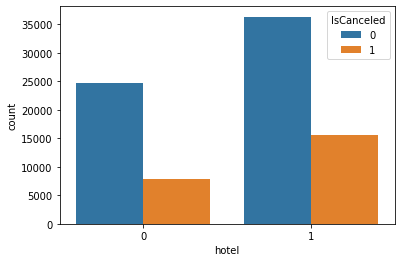

In [ ]:
sns.countplot(data=df, x='hotel', hue='IsCanceled')

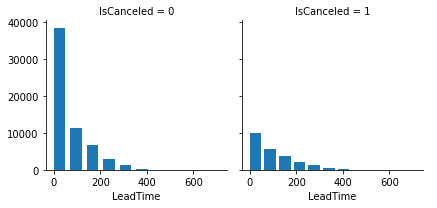

In [ ]:
grid = sns.FacetGrid(df, col='IsCanceled')
grid.map(plt.hist, 'LeadTime', width=50)
grid.add_legend()

Cancelations among new guests=  0.284796468857283
Cancelations among old guests=  0.08264462809917356


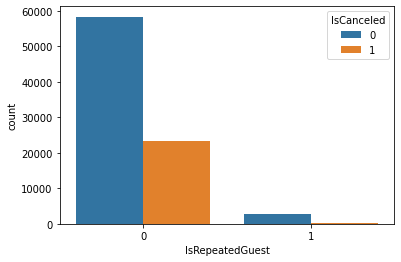

In [ ]:
sns.countplot(data=df, x='IsRepeatedGuest', hue='IsCanceled')
new_guest = df[(df['IsRepeatedGuest']==0) & (df['IsCanceled']==1)]
old_guest = df[(df['IsRepeatedGuest']==1) & (df['IsCanceled']==1)]
print('Cancelations among new guests= ', (len(new_guest))/(len(df[df['IsRepeatedGuest']==0])))
print('Cancelations among old guests= ', (len(old_guest))/(len(df[df['IsRepeatedGuest']==1])))

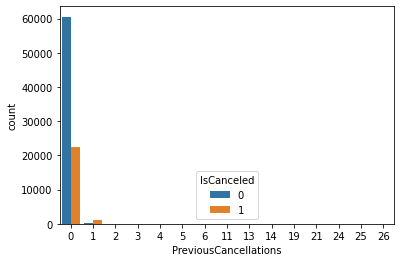

In [ ]:
sns.countplot(data=df, x='PreviousCancellations', hue='IsCanceled')

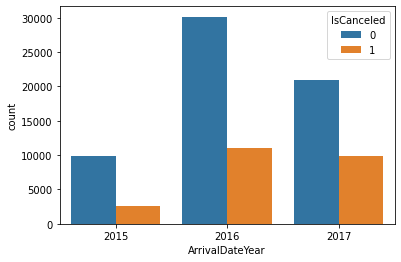

In [ ]:
sns.countplot(data=df, x='ArrivalDateYear', hue='IsCanceled')


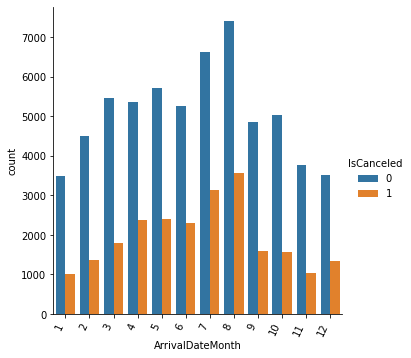

In [ ]:
chart = sns.catplot(data=df, x='ArrivalDateMonth', hue='IsCanceled', kind='count')
chart.set_xticklabels(rotation=65, horizontalalignment='right')

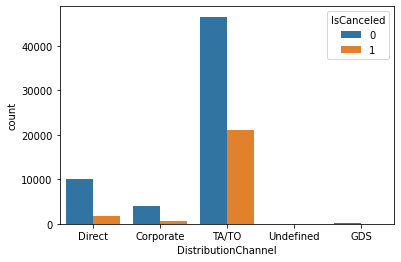

In [ ]:
sns.countplot(data=df, x='DistributionChannel', hue='IsCanceled')


Transient          82.481294
Transient-Party    13.289686
Contract            3.632317
Group               0.596704
Name: CustomerType, dtype: float64


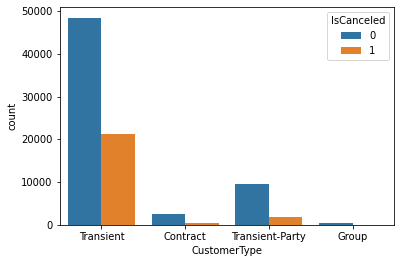

In [ ]:
print(df['CustomerType'].value_counts(normalize=True)*100)
sns.countplot(data=df, x='CustomerType', hue='IsCanceled')

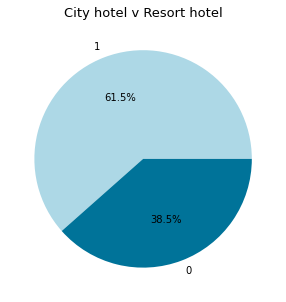

In [ ]:
labels = df.hotel.value_counts().index
sizes = df.hotel.value_counts()
plt.figure(figsize = (5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',colors = ['#ADD8E6','#007399'])
plt.title('City hotel v Resort hotel',color = 'black',fontsize = 13);

In [ ]:
#dealing with dates is tricky in a neural network. I think the best approach is to use the difference between arrival date and reservation date as data input
#first, merge the arrival date columns into a single string:
df["ArrivalDate"] = df["ArrivalDateYear"].astype(str) + "-" + df["ArrivalDateMonth"].astype(str) + "-" + df["ArrivalDateDayOfMonth"].astype(str)

#then we get the date difference by casting the dates as datetime objects and using datediff, pasting that value into a new column
df["ArrivalDate"] = pd.to_datetime(df["ArrivalDate"])
df["ReservationStatusDate"] = pd.to_datetime(df["ReservationStatusDate"])

df["DateDiff"] = (df["ArrivalDate"] - df["ReservationStatusDate"]).astype(int) #need to save it as an int rather than np time difference for neural network
df.head(20) #these results are very strange -- Arrival date is sometimes later than reservation status date. I will keep it in any case but it should be explored

#we can then drop the arrival date and reservation date columns
df.drop(columns=["ArrivalDateYear", "ArrivalDateWeekNumber", "ArrivalDateDayOfMonth", "ArrivalDateMonth", "ReservationStatusDate", "ArrivalDate"], inplace=True)

In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap = 'coolwarm')

,IsCanceled,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,average_daily_rate,RequiredCarParkingSpaces,TotalOfSpecialRequests,hotel,DateDiff
IsCanceled,1.000000,0.181392,0.057118,0.079771,0.080655,0.066908,-0.020092,-0.082229,0.053375,-0.048167,-0.092540,0.004946,0.116728,-0.185176,-0.123647,0.065797,0.619244
LeadTime,0.181392,1.000000,0.230208,0.308906,0.141862,0.027209,-0.003403,-0.135431,0.009910,-0.072167,0.079964,0.131757,0.002113,-0.086882,0.036810,-0.035110,0.415229
StaysInWeekendNights,0.057118,0.230208,1.000000,0.539747,0.099857,0.027995,0.015105,-0.093465,-0.017185,-0.049099,0.027708,-0.033641,0.014207,-0.044648,0.032546,-0.169032,0.056311
StaysInWeekNights,0.079771,0.308906,0.539747,1.000000,0.110563,0.029513,0.016649,-0.097037,-0.016013,-0.053697,0.059420,-0.000197,0.025832,-0.045746,0.036887,-0.225601,0.087950
Adults,0.080655,0.141862,0.099857,0.110563,1.000000,0.026680,0.019425,-0.206094,-0.047162,-0.143072,-0.046894,-0.016622,0.302587,0.011117,0.143508,0.012491,0.075868
Children,0.066908,0.027209,0.027995,0.029513,0.026680,1.000000,0.015999,-0.043504,-0.018061,-0.027530,0.033668,-0.020341,0.335711,0.037248,0.043384,-0.020732,0.057733
Babies,-0.020092,-0.003403,0.015105,0.016649,0.019425,0.015999,1.000000,-0.013291,-0.005156,-0.008856,0.084992,-0.006729,0.025142,0.030313,0.092762,-0.040472,-0.015464
IsRepeatedGuest,-0.082229,-0.135431,-0.093465,-0.097037,-0.206094,-0.043504,-0.013291,1.000000,0.200787,0.447706,0.008033,-0.011510,-0.117874,0.080417,-0.009625,-0.059712,-0.053604
PreviousCancellations,0.053375,0.009910,-0.017185,-0.016013,-0.047162,-0.018061,-0.005156,0.200787,1.000000,0.384293,-0.009781,0.004282,-0.044927,-0.002492,-0.005707,0.015091,0.050247
PreviousBookingsNotCanceled,-0.048167,-0.072167,-0.049099,-0.053697,-0.143072,-0.027530,-0.008856,0.447706,0.384293,1.000000,0.007093,-0.005652,-0.071386,0.044014,0.012416,0.003705,-0.032062


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84464 entries, 2 to 79329
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   84464 non-null  int64  
 1   LeadTime                     84464 non-null  int64  
 2   StaysInWeekendNights         84464 non-null  int64  
 3   StaysInWeekNights            84464 non-null  int64  
 4   Adults                       84464 non-null  int64  
 5   Children                     84464 non-null  float64
 6   Babies                       84464 non-null  int64  
 7   Meal                         84464 non-null  object 
 8   Country                      84464 non-null  object 
 9   MarketSegment                84464 non-null  object 
 10  DistributionChannel          84464 non-null  object 
 11  IsRepeatedGuest              84464 non-null  int64  
 12  PreviousCancellations        84464 non-null  int64  
 13  PreviousBookings

In [ ]:
#df_corr = df[df.columns[1:]].apply(lambda x: x.corr(df['IsCanceled']))
#df_corr = df_corr.to_frame()
#pd.options.display.max_rows
#df_corr

#print(df["IsCanceled"].corr(df["ReservationStatus_Canceled"]))
#print(df["IsCanceled"].corr(df["ReservationStatus_Check-Out"]))

# we found that ReservaionStatus is too well-correlated
df.drop(columns="ReservationStatus", inplace=True)

In [ ]:
df = pd.get_dummies(df, dummy_na=True)

In [ ]:
X = df.loc[:, df.columns != 'IsCanceled']
y = df.loc[:, df.columns == 'IsCanceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)

In [ ]:
standardScaler = StandardScaler()
X_train = standardScaler.fit_transform(X_train)
X_test = standardScaler.transform(X_test)

In [ ]:
classifier = Sequential()
classifier.add(Dense(units = 32, activation = 'relu', input_dim = 917))
classifier.add(Dropout(rate = 0.6))
classifier.add(Dense(units = 32, activation = 'relu'))
classifier.add(Dropout(rate = 0.6))
classifier.add(Dense(units = 64, activation = 'relu'))
classifier.add(Dropout(rate = 0.6))
classifier.add(Dense(units = 32, activation = 'relu'))
classifier.add(Dropout(rate = 0.4))
classifier.add(Dense(units = 1, activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                29376     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [ ]:
history = classifier.fit(X_train, y_train, epochs = 10, shuffle = False, validation_split = 0.1)

Epoch 1/10
1901/1901 [==============================] - 6s 3ms/step - loss: 0.4377 - accuracy: 0.8187 - val_loss: 0.2337 - val_accuracy: 0.9121
Epoch 2/10
1901/1901 [==============================] - 5s 3ms/step - loss: 0.2560 - accuracy: 0.9143 - val_loss: 0.1819 - val_accuracy: 0.9268
Epoch 3/10
1901/1901 [==============================] - 5s 3ms/step - loss: 0.2159 - accuracy: 0.9258 - val_loss: 0.1608 - val_accuracy: 0.9376
Epoch 4/10
1901/1901 [==============================] - 5s 3ms/step - loss: 0.1962 - accuracy: 0.9329 - val_loss: 0.1497 - val_accuracy: 0.9414
Epoch 5/10
1901/1901 [==============================] - 5s 3ms/step - loss: 0.1835 - accuracy: 0.9380 - val_loss: 0.1399 - val_accuracy: 0.9438
Epoch 6/10
1901/1901 [==============================] - 5s 3ms/step - loss: 0.1685 - accuracy: 0.9424 - val_loss: 0.1345 - val_accuracy: 0.9457
Epoch 7/10
1901/1901 [==============================] - 6s 3ms/step - loss: 0.1589 - accuracy: 0.9464 - val_loss: 0.1260 - val_accuracy:

In [ ]:
y_pred = classifier.predict(X_test)
y_pred = y_pred > 0.5

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred)*100))

Confusion matrix:
[[11772   457]
 [  198  4466]]
Accuracy: 96.12%
